# Mini project - Deep Learning and Computer Vision
### Manuela Valencia Toro - 240427850

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The first step is to import all the needed libraries. All models will be created using pytorch and the data (MNIST and CIFAR) is going to be extracted from torchvision

In [2]:
!pip install --upgrade torchmetrics
folder_path = ""
import os,sys
import numpy as np
import time
import matplotlib.pyplot as plt
sys.path.append(folder_path)
import importlib
import seaborn as sns
import torchmetrics
import torch
from torch import optim,nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
from torchmetrics.classification import (
    Accuracy,
    Precision,
    Recall,
    F1Score,
    MulticlassConfusionMatrix
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Implemented architectures:

### VGG-16
This architecture consists of 16 convolutional layers, each one with 3x3 filters.


In [18]:
class VGG(nn.Module):

  def __init__(self,num_classes):
        super(VGG,self).__init__()
        self.cnn = nn.Sequential(
            #First block 224x224
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #Second block 112x112
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #Third block 56x56
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #fourth block 28x28
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #fifth block 14x14
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #final block 7x7
            nn.Flatten(),
            nn.Linear(7*7*512,4096),
            nn.ReLU(),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Linear(4096,num_classes)
            #This architecture is based on Digital Ocean implementation
        )

  def forward(self,x):
        x = self.cnn(x)
        return x


### Modified VGG (For 28x28)

The strucure of VGG16 is modified to adapt it to the MNIST dataset, especially making it able to work with 28x28 images.

In [3]:
class VGG_MNIST(nn.Module):
    def __init__(self, num_classes):
        super(VGG_MNIST, self).__init__()
        self.cnn = nn.Sequential(
            # Input: 1x28x28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # 28x28
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 7x7

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 7x7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 3x3

            nn.Flatten(),                                 # 128 * 3 * 3
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.cnn(x)


### ResNet Model
this model solved the problem of network performance degrading if the network is too deep. It also introduced the concept of Residual Connections



In [4]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
            #This architecture is based on Digital Ocean implementation

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

### Modified ResNet (28x28)

Resnet architecture is also simplified in order to reduce the execution time and to avoid processing extra data and noise. To acomplish it, the number of layers in the residual blocks and the output size are reduced.

In [5]:
class ResNetMNIST(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetMNIST, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Changed from 7x7 to 3x3
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Instead of 7x7
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Data preprocessing

Transform the input data (MNIST) into tensor, resize it into 28x28 and normalize the data around 0 in order to stabilize training

In [8]:
# Transform to Tensor, resize and normalize [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]


# Training




Here all the hyperparameters needed to train and test both models are defined. I defined a good relationship batch size/epochs is 128/10 since it enables the model learn improtant patterns from the data while maintaining a good execution time.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.0001
generator = torch.Generator().manual_seed(10)
train_dataset, validation_dataset = random_split(train_dataset, [0.8,0.2],generator=generator)
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
confmat = MulticlassConfusionMatrix(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
f1 = F1Score(task="multiclass", average="macro", num_classes=10).to(device)
log_file = os.path.join(folder_path, "training_log.txt")
logging.basicConfig(
      filename=log_file,
      level=logging.INFO,
      format='%(asctime)s %(levelname)s:%(message)s',
      filemode='a'
      )

An example of the data to feed the models

Shape:  torch.Size([28, 28])
Ground Truth: [8, 4, 0, 0, 1]


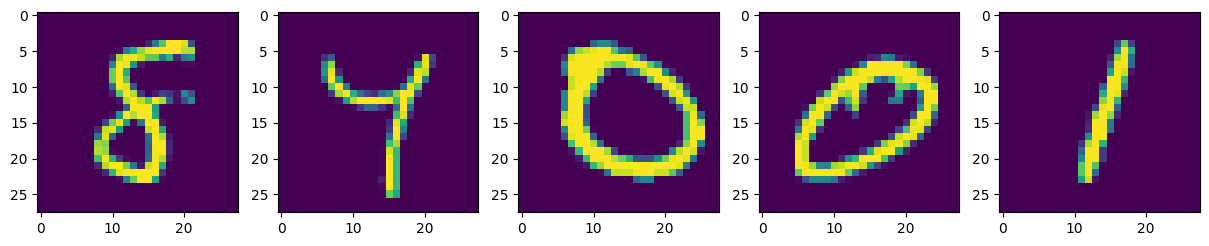

In [9]:
fix,axes = plt.subplots(1,5,figsize=(15,15))
for i in range(5):
  axes[i].imshow(train_dataset[i][0][0])
print("Shape: ",train_dataset[0][0][0].shape)
print("Ground Truth:",[train_dataset[i][1] for i in range(5)])

### Training and validation loops:

In [10]:
class TrainModelWithMnist():

  def __init__(self,model,train_loader, val_loader, EPOCHS, batch_size, LR, model_name):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.EPOCHS = EPOCHS
    self.batch_size = batch_size
    self.LR = LR
    self.model_name = model_name
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model.to(self.device)
    self.optimizer = optim.AdamW(self.model.parameters(), lr=self.LR)

    #Define performance metrics
    self.loss_list,self.val_loss_list, self.accuracy_list, self.f1_list = [0]*EPOCHS,[0]*EPOCHS,[0]*EPOCHS,[0]*EPOCHS

  def _training_epoch(self,epoch):
    self.model.train()
    train_running_loss = 0
    for idx, img_target in enumerate(tqdm(self.train_loader)):
        img,target = img_target[0].to(self.device), img_target[1].to(self.device)
        pred = self.model(img)
        loss= criterion(pred,target)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        train_running_loss += loss.item()

    return train_running_loss

  def _validation_epoch(self,epoch):
      self.model.eval()
      validation_running_loss = 0
      accuracy_val = 0
      f1_val = 0
      with torch.no_grad():
          for idx, img_target in enumerate(tqdm(self.val_loader)):
                img,target = img_target[0].to(self.device), img_target[1].to(self.device)
                pred = self.model(img)
                loss= criterion(pred,target)
                accuracy_val += accuracy(pred,target).item()
                f1_val += f1(pred,target).item()
                validation_running_loss += loss.item()

      return validation_running_loss, accuracy_val, f1_val

  def train_model(self):
    logging.info('-' * 50)
    logging.info(f"{self.model_name} Model (epochs: 10, batch size: 128)")
    for epoch in tqdm(range(self.EPOCHS)):
        train_running_loss = self._training_epoch(epoch)
        validation_running_loss, accuracy_val, f1_val = self._validation_epoch(epoch)
        self.loss_list[epoch] = train_running_loss/len(self.train_loader)
        self.accuracy_list[epoch] = accuracy_val/len(self.val_loader)
        self.f1_list[epoch] = f1_val/len(self.val_loader)
        self.val_loss_list[epoch] = validation_running_loss/len(self.val_loader)
        print(f"Training Loss: {self.loss_list[epoch]:.6f}, Validation Loss: {self.val_loss_list[epoch]:.6f}, Validation Accuracy: {self.accuracy_list[epoch]:.6f}%, , Validation f1: {self.f1_list[epoch]:.6f}")
    torch.save(self.model.state_dict(), folder_path+f"mnist_{self.model_name}.pth")
    logging.info(f"training loss"+str(self.loss_list))
    logging.info(f"val loss"+str(self.val_loss_list))
    logging.info(f"val accuracy "+str(self.accuracy_list))
    logging.info(f"val f1 "+str(self.f1_list))
    return self.loss_list, self.val_loss_list, self.accuracy_list, self.f1_list

### Testing loop:

In [11]:
def test_model(test_loader,weights_file,model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.load_state_dict(torch.load(folder_path+weights_file))
    model.to(device)
    model.eval()
    test_running_loss = 0
    accuracy_test = 0
    f1_test = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for idx, img_target in enumerate(test_loader):
              img,target = img_target[0].to(device), img_target[1].to(device)
              pred = model(img)
              y_true += target.tolist()
              y_pred += pred.argmax(1).tolist()
        y_true = torch.tensor(y_true).to(device)
        y_pred = torch.tensor(y_pred).to(device)
        accuracy_test = accuracy(y_pred,y_true).item()
        f1_test = f1(y_pred,y_true).item()
    logging.info('-' * 50)
    logging.info(f"testing Model (batch size: 128)")
    logging.info(f"Test Accuracy: {accuracy_test:.6f}%, Test f1: {f1_test:.6f}")
    return accuracy_test, f1_test, confmat(y_pred,y_true)

### Train VGG MNIST modified

In [12]:
start_time = time.time()
VGG_model = VGG_MNIST(10).to(device)
vgg_trainer = TrainModelWithMnist(VGG_model,train_dataloader, validation_dataloader, EPOCHS, BATCH_SIZE, LR, "VGG")
tloss,vloss,acc,f1v= vgg_trainer.train_model()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 375/375 [00:29<00:00, 12.85it/s]

 10%|█         | 1/10 [00:32<04:53, 32.66s/it]

Training Loss: 0.838742, Validation Loss: 0.208821, Validation Accuracy: 0.939079%, , Validation f1: 0.936172



100%|██████████| 375/375 [00:14<00:00, 25.89it/s]

 20%|██        | 2/10 [00:50<03:09, 23.67s/it]

Training Loss: 0.192041, Validation Loss: 0.115796, Validation Accuracy: 0.965065%, , Validation f1: 0.963773



100%|██████████| 375/375 [00:14<00:00, 25.15it/s]

 30%|███       | 3/10 [01:08<02:28, 21.23s/it]

Training Loss: 0.129725, Validation Loss: 0.089082, Validation Accuracy: 0.972296%, , Validation f1: 0.970622



100%|██████████| 375/375 [00:14<00:00, 25.77it/s]

 40%|████      | 4/10 [01:26<02:00, 20.16s/it]

Training Loss: 0.100270, Validation Loss: 0.071210, Validation Accuracy: 0.977615%, , Validation f1: 0.976137



100%|██████████| 375/375 [00:15<00:00, 23.59it/s]

 50%|█████     | 5/10 [01:46<01:40, 20.04s/it]

Training Loss: 0.082013, Validation Loss: 0.065742, Validation Accuracy: 0.979555%, , Validation f1: 0.978641



100%|██████████| 375/375 [00:14<00:00, 25.10it/s]

 60%|██████    | 6/10 [02:04<01:17, 19.34s/it]

Training Loss: 0.070516, Validation Loss: 0.053402, Validation Accuracy: 0.982685%, , Validation f1: 0.981466



100%|██████████| 375/375 [00:14<00:00, 25.18it/s]

 70%|███████   | 7/10 [02:22<00:56, 18.87s/it]

Training Loss: 0.062224, Validation Loss: 0.045884, Validation Accuracy: 0.985705%, , Validation f1: 0.984888



100%|██████████| 375/375 [00:15<00:00, 24.33it/s]

 80%|████████  | 8/10 [02:41<00:37, 18.82s/it]

Training Loss: 0.054011, Validation Loss: 0.046216, Validation Accuracy: 0.984874%, , Validation f1: 0.984230



100%|██████████| 375/375 [00:14<00:00, 25.18it/s]

 90%|█████████ | 9/10 [02:59<00:18, 18.53s/it]

Training Loss: 0.049800, Validation Loss: 0.040465, Validation Accuracy: 0.987422%, , Validation f1: 0.986704



100%|██████████| 375/375 [00:14<00:00, 25.11it/s]

100%|██████████| 10/10 [03:17<00:00, 19.78s/it]


Training Loss: 0.044765, Validation Loss: 0.038501, Validation Accuracy: 0.988531%, , Validation f1: 0.988083
--- 199.10675430297852 seconds ---


### Test VGG MNIST modified model

 Test Accuracy: 0.990400, Test f1: 0.990338


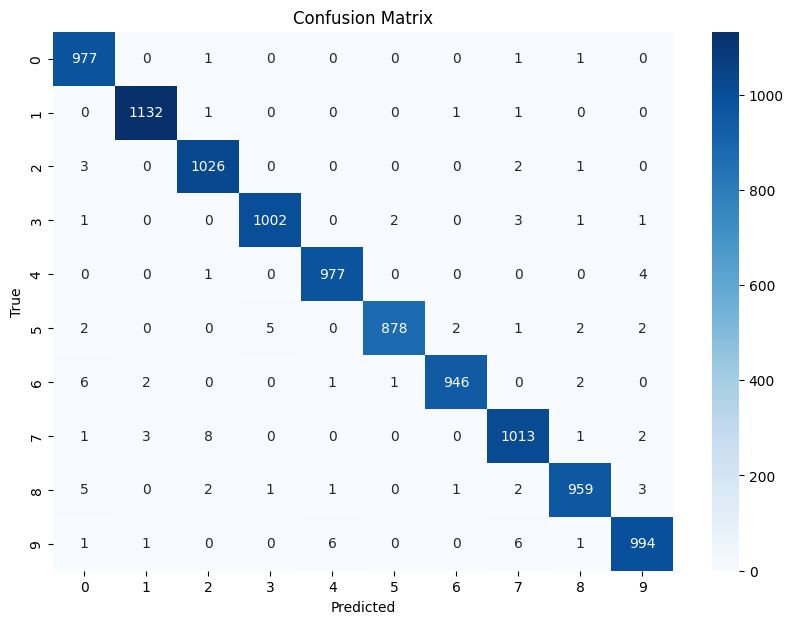

In [13]:
VGG_model = VGG_MNIST(10).to(device)
VGG_test_accuracy, VGG_test_f1, confm = test_model(test_dataloader,"mnist_VGG.pth",VGG_model)
print(f" Test Accuracy: {VGG_test_accuracy:.6f}, Test f1: {VGG_test_f1:.6f}")

plt.figure(figsize=(10, 7))
sns.heatmap(confm.cpu(), annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

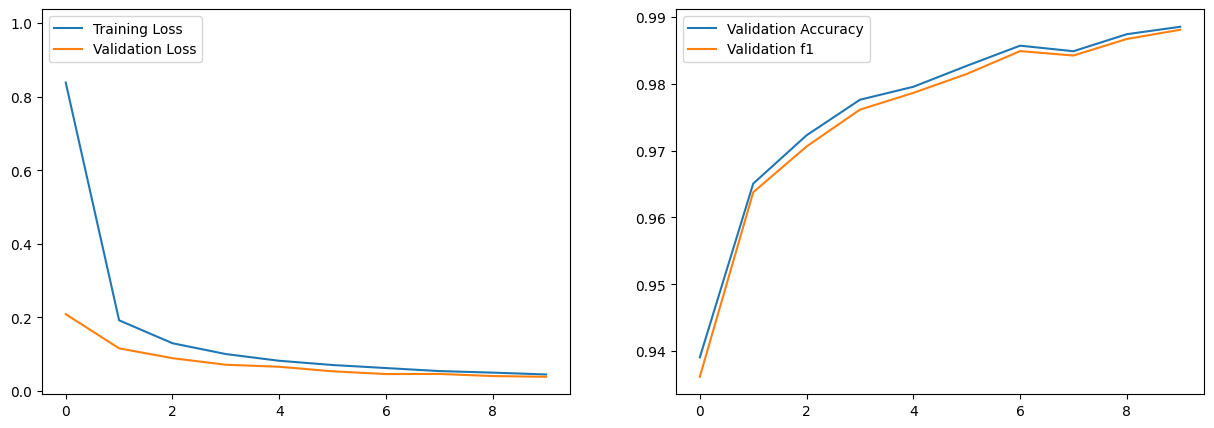

In [14]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(tloss,label="Training Loss")
axes[0].plot(vloss,label="Validation Loss")
axes[0].legend()
axes[1].plot(acc,label="Validation Accuracy")
axes[1].plot(f1v,label="Validation f1")
axes[1].legend()
plt.show()

<Figure size 640x480 with 0 Axes>

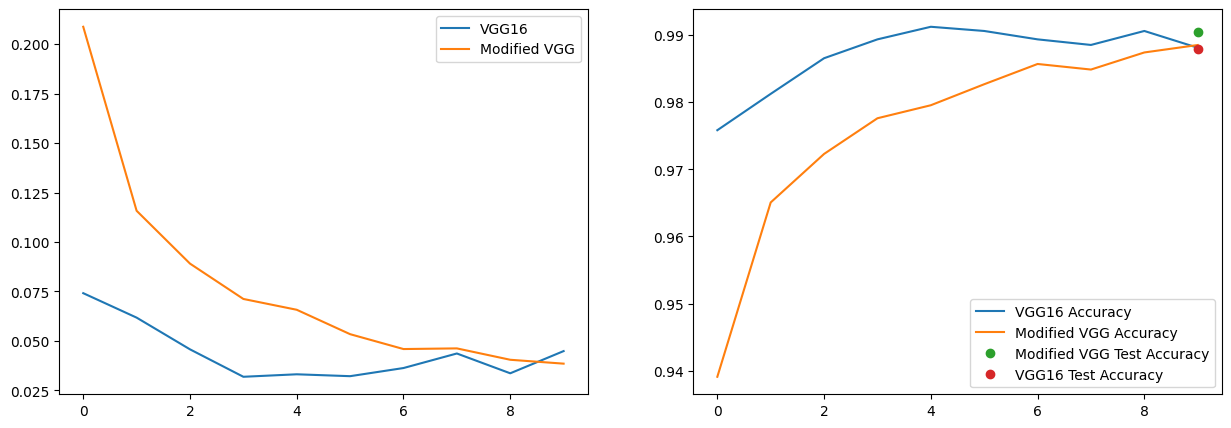

In [19]:
#Took from the execution of VGG16
original_vgg = [0.0741339393829306, 0.06177070913215478, 0.04573346723336726, 0.031864672489464285, 0.03311939157700787, 0.032168276824910816, 0.03628565293620341, 0.04364004488956804, 0.03362553573679179, 0.044852621076473344]
original_vgg_acc = [0.9758333333333333, 0.98125, 0.9865625, 0.989375, 0.99125, 0.990625, 0.989375, 0.9885416666666667, 0.990625, 0.988125]
original_test_acc= 0.988
##################################
plt.figure()
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(original_vgg,label="VGG16")
axes[0].plot(vloss,label="Modified VGG")
axes[0].legend()
axes[1].plot(original_vgg_acc,label="VGG16 Accuracy")
axes[1].plot(acc,label="Modified VGG Accuracy")
axes[1].plot(9,VGG_test_accuracy,'o',label="Modified VGG Test Accuracy")
axes[1].plot(9,original_test_acc,'o',label="VGG16 Test Accuracy")
axes[1].legend()
plt.show()

### Train ResNet MNIST Modified

In [ ]:
start_time = time.time()
resnet_model = ResNetMNIST(ResidualBlock, layers=[1, 1, 1], num_classes=10)
resnet_trainer = TrainModelWithMnist(resnet_model,train_dataloader, validation_dataloader, EPOCHS, BATCH_SIZE, LR, "resnet")
tloss,vloss,acc,f1v= resnet_trainer.train_model()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 300/300 [00:14<00:00, 20.03it/s]

 10%|█         | 1/10 [00:17<02:36, 17.43s/it]

Training Loss: 1.069958, Validation Loss: 0.386252, Validation Accuracy: 0.955937%, , Validation f1: 0.953033



100%|██████████| 300/300 [00:14<00:00, 21.43it/s]

 20%|██        | 2/10 [00:34<02:16, 17.05s/it]

Training Loss: 0.256925, Validation Loss: 0.166345, Validation Accuracy: 0.973854%, , Validation f1: 0.972228



100%|██████████| 300/300 [00:14<00:00, 21.17it/s]

 30%|███       | 3/10 [00:51<01:59, 17.06s/it]

Training Loss: 0.136657, Validation Loss: 0.117584, Validation Accuracy: 0.978437%, , Validation f1: 0.976922



100%|██████████| 300/300 [00:14<00:00, 21.06it/s]

 40%|████      | 4/10 [01:08<01:41, 16.93s/it]

Training Loss: 0.091662, Validation Loss: 0.078626, Validation Accuracy: 0.985625%, , Validation f1: 0.985055



100%|██████████| 300/300 [00:14<00:00, 21.10it/s]

 50%|█████     | 5/10 [01:24<01:24, 16.84s/it]

Training Loss: 0.067711, Validation Loss: 0.065569, Validation Accuracy: 0.986667%, , Validation f1: 0.986136



100%|██████████| 300/300 [00:14<00:00, 20.99it/s]

 60%|██████    | 6/10 [01:42<01:08, 17.12s/it]

Training Loss: 0.053119, Validation Loss: 0.055475, Validation Accuracy: 0.987708%, , Validation f1: 0.987789



100%|██████████| 300/300 [00:14<00:00, 21.10it/s]

 70%|███████   | 7/10 [01:59<00:50, 16.99s/it]

Training Loss: 0.042199, Validation Loss: 0.048890, Validation Accuracy: 0.988958%, , Validation f1: 0.988611



100%|██████████| 300/300 [00:14<00:00, 21.20it/s]

 80%|████████  | 8/10 [02:15<00:33, 16.87s/it]

Training Loss: 0.034114, Validation Loss: 0.043628, Validation Accuracy: 0.989479%, , Validation f1: 0.989082



100%|██████████| 300/300 [00:14<00:00, 21.06it/s]

 90%|█████████ | 9/10 [02:32<00:16, 16.88s/it]

Training Loss: 0.027357, Validation Loss: 0.048444, Validation Accuracy: 0.987292%, , Validation f1: 0.986915



100%|██████████| 300/300 [00:14<00:00, 20.87it/s]

100%|██████████| 10/10 [02:49<00:00, 16.99s/it]

Training Loss: 0.022927, Validation Loss: 0.037226, Validation Accuracy: 0.990417%, , Validation f1: 0.990229
--- 169.96977496147156 seconds ---


In [ ]:
import time
start_time = time.time()
resnet_model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
resnet_trainer = TrainModelWithMnist(resnet_model,train_dataloader, validation_dataloader, EPOCHS, BATCH_SIZE, LR, "resnet")
tloss,vloss,acc,f1= resnet_trainer.train_model()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 375/375 [04:12<00:00,  1.49it/s]

 10%|█         | 1/10 [04:38<41:44, 278.25s/it]

Training Loss: 0.128113, Validation Loss: 0.259167, Validation Accuracy: 0.918744%, , Validation f1: 0.916674



100%|██████████| 375/375 [04:14<00:00,  1.48it/s]

 20%|██        | 2/10 [09:18<37:14, 279.37s/it]

Training Loss: 0.035150, Validation Loss: 0.086725, Validation Accuracy: 0.970135%, , Validation f1: 0.968579



100%|██████████| 375/375 [04:14<00:00,  1.47it/s]

 30%|███       | 3/10 [13:58<32:39, 279.90s/it]

Training Loss: 0.026896, Validation Loss: 0.055134, Validation Accuracy: 0.983710%, , Validation f1: 0.983159



100%|██████████| 375/375 [04:14<00:00,  1.47it/s]

 40%|████      | 4/10 [18:39<28:01, 280.25s/it]

Training Loss: 0.022007, Validation Loss: 0.039984, Validation Accuracy: 0.988808%, , Validation f1: 0.988107



100%|██████████| 375/375 [04:14<00:00,  1.47it/s]

 50%|█████     | 5/10 [23:20<23:23, 280.62s/it]

Training Loss: 0.015681, Validation Loss: 0.034652, Validation Accuracy: 0.989002%, , Validation f1: 0.988443



100%|██████████| 375/375 [04:15<00:00,  1.47it/s]

 60%|██████    | 6/10 [28:02<18:43, 280.90s/it]

Training Loss: 0.017100, Validation Loss: 0.030331, Validation Accuracy: 0.990775%, , Validation f1: 0.990329



100%|██████████| 375/375 [04:15<00:00,  1.47it/s]

 70%|███████   | 7/10 [32:44<14:04, 281.43s/it]

Training Loss: 0.014341, Validation Loss: 0.075584, Validation Accuracy: 0.975039%, , Validation f1: 0.974836



100%|██████████| 375/375 [04:16<00:00,  1.46it/s]

 80%|████████  | 8/10 [37:27<09:23, 281.86s/it]

Training Loss: 0.012595, Validation Loss: 0.028319, Validation Accuracy: 0.991301%, , Validation f1: 0.990750



100%|██████████| 375/375 [04:16<00:00,  1.46it/s]

 90%|█████████ | 9/10 [42:11<04:42, 282.31s/it]

Training Loss: 0.011150, Validation Loss: 0.043771, Validation Accuracy: 0.989002%, , Validation f1: 0.988299



100%|██████████| 375/375 [04:16<00:00,  1.46it/s]

100%|██████████| 10/10 [46:54<00:00, 281.40s/it]


Training Loss: 0.010770, Validation Loss: 0.027043, Validation Accuracy: 0.993323%, , Validation f1: 0.993053
--- 2815.0665543079376 seconds ---


### Test ResNet MNIST modified model

 Test Accuracy: 0.989800, Test f1: 0.989743


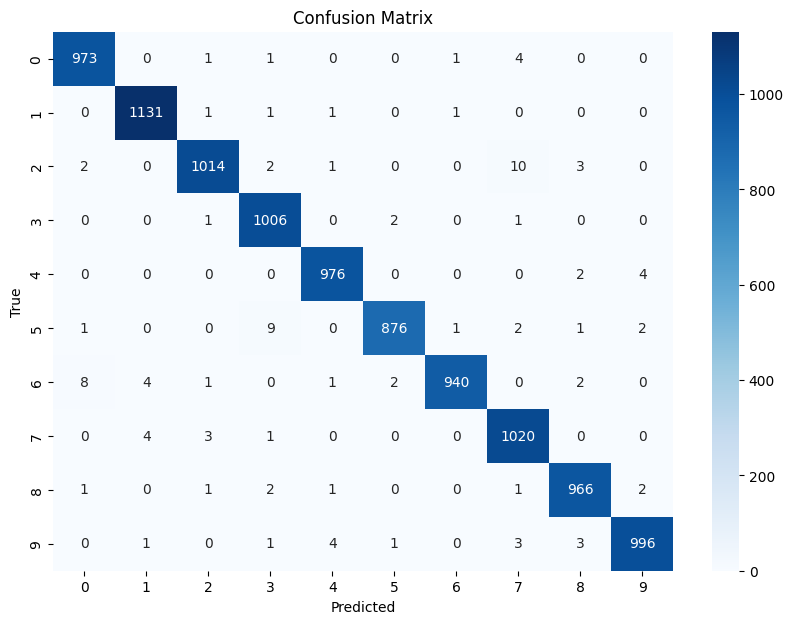

In [ ]:
resnet_model = ResNetMNIST(ResidualBlock, layers=[1, 1, 1], num_classes=10)
resnet_test_accuracy, resnet_test_f1, confmat = test_model(test_dataloader,"mnist_resnet.pth",resnet_model)
print(f" Test Accuracy: {resnet_test_accuracy:.6f}, Test f1: {resnet_test_f1:.6f}")
plt.figure(figsize=(10, 7))
sns.heatmap(confmat.cpu(), annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

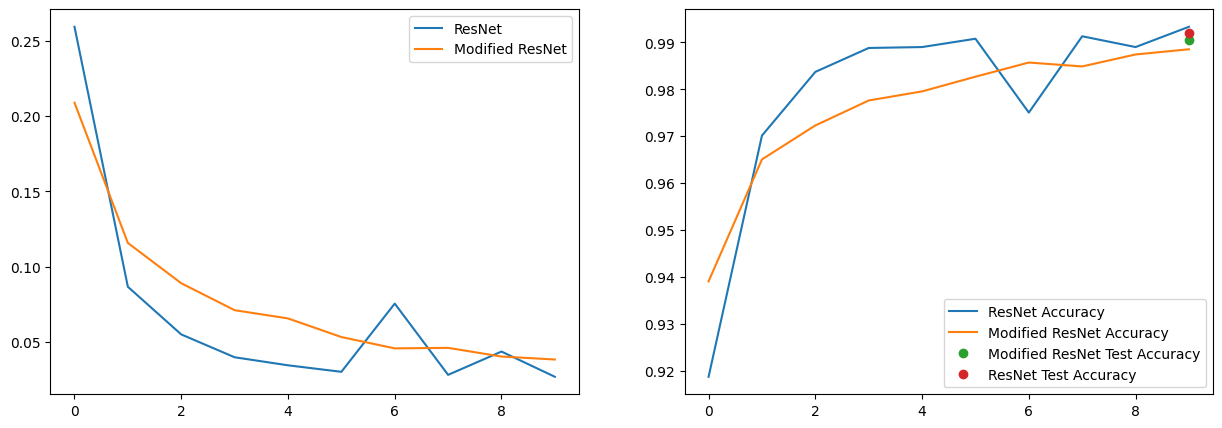

In [20]:
#Took from the execution of ResNet34
org_resnet_loss = [0.25916720221334316, 0.0867248309300618, 0.055133661225517376, 0.039984275041980315, 0.03465190379969538, 0.0303305071033042, 0.07558446575669532, 0.02831900361590979, 0.043771047360620444, 0.027042642860869045]
org_resnet_acc= [0.9187444594312222, 0.970135194824097, 0.9837101063829787, 0.9888076243248392, 0.9890015512070758, 0.9907746010638298, 0.975038785249629, 0.9913009753886689, 0.9890015512070758, 0.993323359717714]
org_res_acc = 0.992
#######################################
plt.figure()
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(org_resnet_loss,label="ResNet")
axes[0].plot(vloss,label="Modified ResNet")
axes[0].legend()
axes[1].plot(org_resnet_acc,label="ResNet Accuracy")
axes[1].plot(acc,label="Modified ResNet Accuracy")
axes[1].plot(9,resnet_test_accuracy,'o',label="Modified ResNet Test Accuracy")
axes[1].plot(9,org_res_acc,'o',label="ResNet Test Accuracy")
axes[1].legend()
plt.show()

# Testing proposed models with CIFAR10

In [14]:
class VGG_MNIST(nn.Module):
    def __init__(self, num_classes):
        super(VGG_MNIST, self).__init__()
        self.cnn = nn.Sequential(
            # Input: 3x28x28
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 28x28
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 7x7

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 7x7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 3x3

            nn.Flatten(),                                 # 128 * 3 * 3
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.cnn(x)


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
generator = torch.Generator().manual_seed(10)
train_dataset, validation_dataset = random_split(train_dataset, [0.8,0.2],generator=generator)
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

In [15]:
start_time = time.time()
VGG_model = VGG_MNIST(10).to(device)
vgg_trainer = TrainModelWithMnist(VGG_model,train_dataloader, validation_dataloader, EPOCHS, BATCH_SIZE, LR, "VGGCIFAR")
tloss,vloss,acc,f1v= vgg_trainer.train_model()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 313/313 [00:18<00:00, 16.50it/s]

 10%|█         | 1/10 [00:25<03:50, 25.64s/it]

Training Loss: 2.018750, Validation Loss: 1.793676, Validation Accuracy: 0.353540%, , Validation f1: 0.318281



100%|██████████| 313/313 [00:18<00:00, 17.07it/s]

 20%|██        | 2/10 [00:47<03:09, 23.64s/it]

Training Loss: 1.711489, Validation Loss: 1.596853, Validation Accuracy: 0.426424%, , Validation f1: 0.406464



100%|██████████| 313/313 [00:20<00:00, 15.39it/s]

 30%|███       | 3/10 [01:12<02:47, 23.90s/it]

Training Loss: 1.579934, Validation Loss: 1.506599, Validation Accuracy: 0.461234%, , Validation f1: 0.446322



100%|██████████| 313/313 [00:18<00:00, 16.62it/s]

 40%|████      | 4/10 [01:35<02:22, 23.71s/it]

Training Loss: 1.508735, Validation Loss: 1.450383, Validation Accuracy: 0.481507%, , Validation f1: 0.467565



100%|██████████| 313/313 [00:18<00:00, 16.96it/s]

 50%|█████     | 5/10 [01:58<01:57, 23.51s/it]

Training Loss: 1.459672, Validation Loss: 1.417725, Validation Accuracy: 0.490902%, , Validation f1: 0.477334



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]

 60%|██████    | 6/10 [02:21<01:33, 23.32s/it]

Training Loss: 1.417167, Validation Loss: 1.394523, Validation Accuracy: 0.501286%, , Validation f1: 0.484693



100%|██████████| 313/313 [00:19<00:00, 16.23it/s]

 70%|███████   | 7/10 [02:45<01:10, 23.42s/it]

Training Loss: 1.383953, Validation Loss: 1.358499, Validation Accuracy: 0.515625%, , Validation f1: 0.502427



100%|██████████| 313/313 [00:18<00:00, 16.96it/s]

 80%|████████  | 8/10 [03:08<00:46, 23.29s/it]

Training Loss: 1.351529, Validation Loss: 1.324191, Validation Accuracy: 0.525020%, , Validation f1: 0.513046



100%|██████████| 313/313 [00:18<00:00, 17.03it/s]

 90%|█████████ | 9/10 [03:31<00:23, 23.14s/it]

Training Loss: 1.320860, Validation Loss: 1.310696, Validation Accuracy: 0.534513%, , Validation f1: 0.525791



100%|██████████| 313/313 [00:20<00:00, 15.44it/s]

100%|██████████| 10/10 [03:55<00:00, 23.53s/it]

Training Loss: 1.291061, Validation Loss: 1.267610, Validation Accuracy: 0.545787%, , Validation f1: 0.532749
--- 235.30341744422913 seconds ---


 Test Accuracy: 0.551400, Test f1: 0.547262


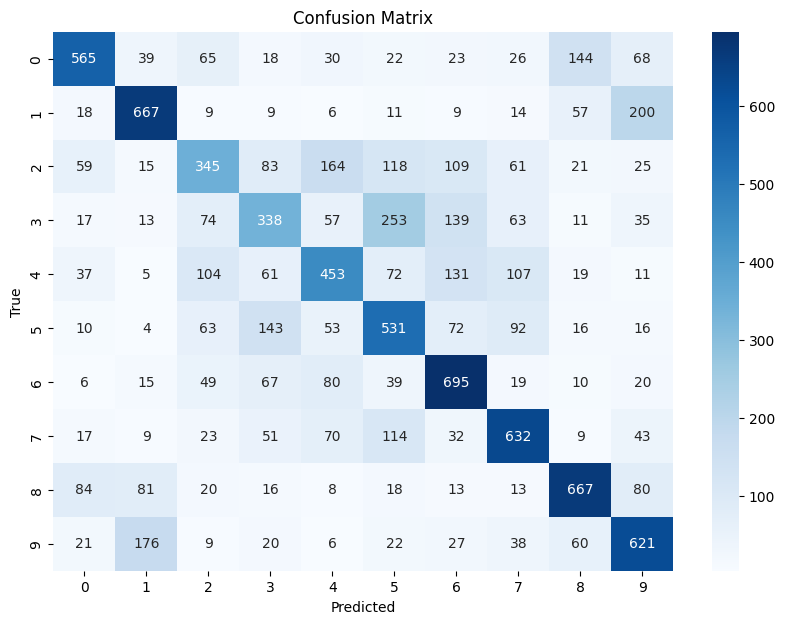

In [16]:
VGG_model = VGG_MNIST(10).to(device)
VGG_test_accuracy, VGG_test_f1, confm = test_model(test_dataloader,"mnist_VGGCIFAR.pth",VGG_model)
print(f" Test Accuracy: {VGG_test_accuracy:.6f}, Test f1: {VGG_test_f1:.6f}")

plt.figure(figsize=(10, 7))
sns.heatmap(confm.cpu(), annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

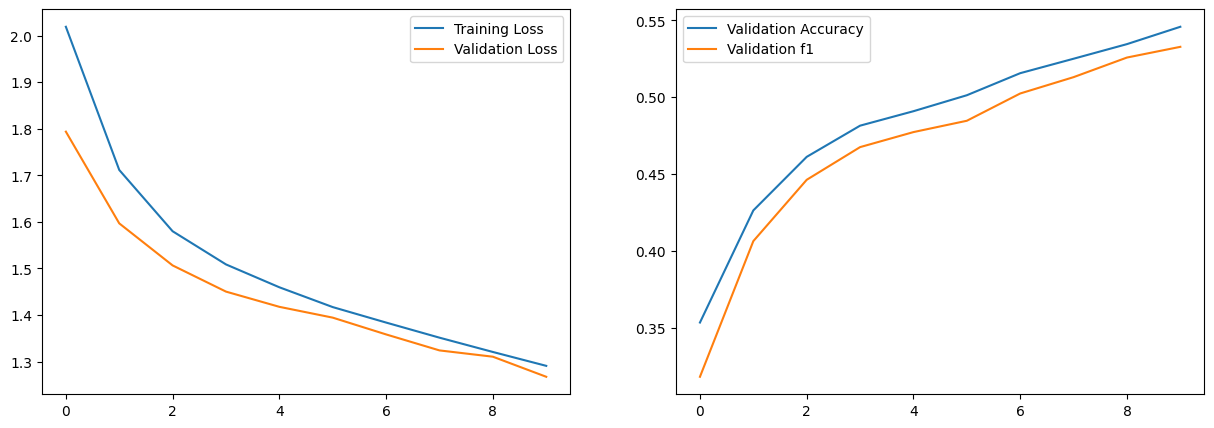

In [17]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(tloss,label="Training Loss")
axes[0].plot(vloss,label="Validation Loss")
axes[0].legend()
axes[1].plot(acc,label="Validation Accuracy")
axes[1].plot(f1v,label="Validation f1")
axes[1].legend()
plt.show()